In [11]:
# ============================================================
# LIBRERÍAS
# ============================================================
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# ============================================================
# DICCIONARIO DE PROPIEDADES
# ============================================================
propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "material temperature [eV]",
    6: "rad intensity group 1 [W/m2]",
    7: "rad intensity group 2 [W/m2]",
    8: "rad intensity group 3 [W/m2]",
    9: "rad intensity group 4 [W/m2]",
    10: "rad intensity group 5 [W/m2]",
    11: "rad intensity group 6 [W/m2]",
    12: "rad intensity group 7 [W/m2]",
    13: "rad intensity group 8 [W/m2]",
    14: "integrated radiation intensity [W/m2]",
    15: "volumetric energy source [W/m3]",
    16: "radiation temperature [eV]",
    17: "rho*Cv [J/m3/K]",
    18: "dT_emission"
}

# ============================================================
# OBTENER RUTA DEL .NPY
# ============================================================
def obtener_ruta_npy(ruta_hdf5, indice_propiedad):
    """
    Ignora completamente el .h5.
    Usa la carpeta con el mismo nombre.
    """
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")

    if not os.path.exists(ruta):
        raise FileNotFoundError(f"No existe {ruta}")

    return ruta, carpeta

# %% Función inteligente de tiempos equiespaciados
def _tiempos_equiespaciados(tiempos, n_tiempos):
    """
    Devuelve índices equiespaciados en tiempo físico.
    - Si los tiempos están uniformes, devuelve índices equiespaciados por posición.
    - Si no están uniformes, interpola en tiempo físico.
    """
    tiempos = np.array(tiempos)
    Nt = len(tiempos)
    
    dt = np.diff(tiempos)
    if np.allclose(dt, dt[0], rtol=1e-3, atol=1e-12):
        # Tiempos uniformes → índices equiespaciados
        return np.linspace(0, Nt-1, n_tiempos, dtype=int)
    
    # Tiempos no uniformes → equiespaciados en tiempo físico
    t_ini = tiempos[0]
    t_fin = tiempos[-1]
    tiempos_obj = np.linspace(t_ini, t_fin, n_tiempos)
    indices = [np.argmin(np.abs(tiempos - t)) for t in tiempos_obj]
    return np.array(indices)


import numpy as np
import h5py
import matplotlib.pyplot as plt

def plot_propiedad_vs_z(ruta_hdf5, indice_propiedad, n_tiempos=5, rmin=None, rmax=None):
    """
    Grafica la propiedad `indice_propiedad` vs Z.
    - Si no hay .h5, busca el .npy en la carpeta del mismo nombre.
    - rmin/rmax: rango de índices de R a promediar.
    - n_tiempos: cantidad de curvas en el plot (equiespaciadas en tiempo).
    """
    # --------------------------------------------------
    # Cargar datos usando SIEMPRE _obtener_ruta_npy
    # --------------------------------------------------
    ruta_data , _ = obtener_ruta_npy(ruta_hdf5, indice_propiedad)
    data = np.load(ruta_data)  # (Nt, Nz, Nr)

    # --------------------------------------------------
    # Intentar leer tiempos desde el .h5 (si existe)
    # --------------------------------------------------
    tiempos = []
    if ruta_hdf5 is not None and ruta_hdf5.endswith(".h5") and os.path.exists(ruta_hdf5):
        with h5py.File(ruta_hdf5, "r") as f:
            for ds in f.values():
                if "time" in ds.attrs:
                    tiempos.append(ds.attrs["time"][0])

    if len(tiempos) != data.shape[0]:
        tiempos = np.arange(data.shape[0], dtype=float)
    tiempos = np.array(tiempos)

    # Ordenar
    orden = np.argsort(tiempos)
    tiempos = tiempos[orden]
    data = data[orden]

    # Filtrar t > 0
    mask = tiempos > 0
    tiempos = tiempos[mask]
    data = data[mask]

    Nt, Nz, Nr = data.shape

    # Rango de r
    ir0 = 0 if rmin is None else int(rmin)
    ir1 = Nr if rmax is None else int(rmax)

    # Promedio sobre r
    prop_z = data[:, :, ir0:ir1].mean(axis=2)  # shape (Nt, Nz)

    # Tiempos equiespaciados
    idx_t = _tiempos_equiespaciados(tiempos, n_tiempos)
    tiempos_ns = tiempos * 1e9
    z = np.arange(Nz)

    # --------------------------------------------------
    # Plot
    # --------------------------------------------------
    plt.figure(figsize=(8,5))
    for i in idx_t:
        plt.plot(z, prop_z[i], lw=2, label=f"t = {tiempos_ns[i]:.2f} ns")

    plt.xlabel("Z [µm]")
    plt.ylabel(propiedades[indice_propiedad])
    plt.title(f"{propiedades[indice_propiedad]} | r ∈ [{ir0},{ir1}]")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



# ============================================================
# ANIMACIÓN PROPIEDAD VS Z (PROMEDIADA EN R)
# ============================================================
def anim_propiedad_vs_z_mp4(
    ruta_hdf5,
    indice_propiedad,
    rmin=None,
    rmax=None,
    fps=10
):
    """
    Animación propiedad vs Z usando TIEMPO FÍSICO (ns) en el título.
    """

    # --------------------------------------------------
    # Cargar datos .npy
    # --------------------------------------------------
    ruta_npy, carpeta = obtener_ruta_npy(ruta_hdf5, indice_propiedad)
    data = np.load(ruta_npy)   # (Nt, Nz, Nr)

    Nt, Nz, Nr = data.shape

    # --------------------------------------------------
    # Leer tiempos físicos desde el .h5 (si existe)
    # --------------------------------------------------
    tiempos = []
    if ruta_hdf5 is not None and ruta_hdf5.endswith(".h5") and os.path.exists(ruta_hdf5):
        import h5py
        with h5py.File(ruta_hdf5, "r") as f:
            for ds in f.values():
                if "time" in ds.attrs:
                    tiempos.append(ds.attrs["time"][0])

    if len(tiempos) != Nt:
        # fallback: tiempos ficticios
        tiempos = np.arange(Nt, dtype=float)

    tiempos = np.array(tiempos)

    # Ordenar por tiempo
    orden = np.argsort(tiempos)
    tiempos = tiempos[orden]
    data = data[orden]

    # Filtrar t > 0
    mask = tiempos > 0
    tiempos = tiempos[mask]
    data = data[mask]

    tiempos_ns = tiempos * 1e9  # ← ns

    Nt, Nz, Nr = data.shape

    # --------------------------------------------------
    # Promedio radial
    # --------------------------------------------------
    ir0 = 0 if rmin is None else int(rmin)
    ir1 = Nr if rmax is None else int(rmax)

    prop_z = data[:, :, ir0:ir1].mean(axis=2)
    z = np.arange(Nz)

    # --------------------------------------------------
    # Figura
    # --------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 5))
    line, = ax.plot([], [], lw=2)

    ax.set_xlim(0, Nz)
    ax.set_ylim(prop_z.min(), prop_z.max())
    ax.set_xlabel("Z [µm]")
    ax.set_ylabel(propiedades[indice_propiedad])

    titulo = ax.text(
        0.5, 1.10,
        propiedades[indice_propiedad],
        transform=ax.transAxes,
        ha="center",
        fontsize=14,
        weight="bold"
    )

    tiempo_txt = ax.text(
        0.5, 1.02,
        "",
        transform=ax.transAxes,
        ha="center",
        fontsize=10
    )

    # --------------------------------------------------
    # Update
    # --------------------------------------------------
    def update(i):
        line.set_data(z, prop_z[i])
        tiempo_txt.set_text(f"t = {tiempos_ns[i]:.3f} ns")
        return line, tiempo_txt

    ani = FuncAnimation(fig, update, frames=Nt, blit=False)

    # --------------------------------------------------
    # Guardar MP4
    # --------------------------------------------------
    nombre_mp4 = f"prop_{indice_propiedad:02d}_vs_z.mp4"
    ruta_mp4 = os.path.join(carpeta, nombre_mp4)

    writer = FFMpegWriter(fps=fps)
    ani.save(ruta_mp4, writer=writer)
    plt.close(fig)

    print("✔ MP4 guardado en:")
    print(ruta_mp4)



In [13]:
ruta = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LDrad.h5"]
indice_propiedad = 16

for r in ruta:

    anim_propiedad_vs_z_mp4(
        r,
        indice_propiedad,
        rmin=150,
        rmax=200,
        fps=12
    )


✔ MP4 guardado en:
C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LDrad\prop_16_vs_z.mp4


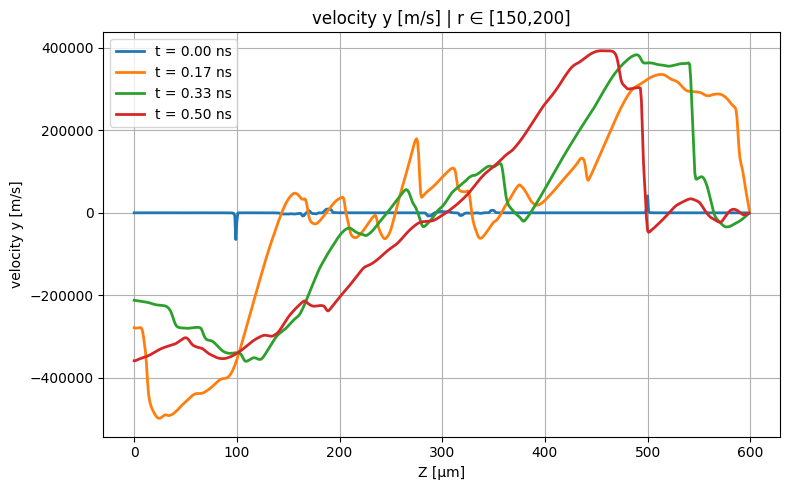

In [4]:
ruta = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD.h5"
indice_propiedad = 7

plot_propiedad_vs_z(
    ruta,
    indice_propiedad,
    n_tiempos=4,
    rmin=150,
    rmax=200
)